In [1]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 5)

from util import util
from scipy.integrate import odeint
import numpy as np
import pandas as pd
from skopt.space import Space

# Training an ML Model

## The Dataset

**So far, we have introduced our simulator**

The rest of our plan is as follows

* We learn an ML model
* We embed the model in a larger optimization problem
* We obtain a solution, i.e. a set of action to control the epidemics

> **But which data are we going to use for training?**

**Since we have a simulator, we can _build_ our dataset**

* This means we can generate as much data as we wish
* ...But also that we are responsible for _how to generate it_

## Building Our Dataset

**We need to define the _structure_ of the dataset**

* We will focus on Non-Therapeutic Interventions (NPI)
  - E.g. mask mandates, social distancing...
* NPIs affect the $\beta$ parameter in a SIR model
  - We will assume to have constant $\gamma$ in our setup
* We will focus on making predictions at weekly intervals

**Therefore, we can cover our needs with...**

For the _input_ part:

* The initial state ($S, I, R$) and the value of $\beta$

For _output_ part:

* The state after one week ($S, I, R$)

**Given an input ($S, I, R, \beta$), we can get the output via simulation**

## Building Our Dataset

**Which input configurations should we generate?**

A training set should be representative of the test distribution

* We do not have a fixed test distribution (no test set)
* ...But we know that the ML model will be _used by an optimizer_

**The optimizer will seek to _minimize the total infections_**

So, we will need:

* High accuracy on the best configurations, so as to _find_ them
* High accuracy on the worst configurations, so as to _avoid_ them

I.e. to be safe the model should work all across the board

**Hence, we need a method that can cover well a given input space**

* The simplest approach would be use use a regular grid
* ...But that approach does not scale well

## Latin Hypercube Sampling

**The method we will use is called _Latin Hypercube Sampling_**

Suppose we want to sample $m$ points for $n$ attributes with fixed ranges

<center><img src="assets/lhs0.png" width=30% /></center>

* We can view the sampling space as a hypercube
* ...Then we divide each dimension in $n$ segments

In the example we want to sample 4 points for 2 attributes

## Latin Hypercube Sampling

**The method we will use is called _Latin Hypercube Sampling_**

Suppose we want to sample $m$ points for $n$ attributes with fixed ranges

<center><img src="assets/lhs1.png" width=30% /></center>

* We sample the first point uniformly at random
* ...Then we "cover" the row and column that contain the sample

## Latin Hypercube Sampling

**The method we will use is called _Latin Hypercube Sampling_**

Suppose we want to sample $m$ points for $n$ attributes with fixed ranges

<center><img src="assets/lhs2.png" width=30% /></center>

* When we take additional samples, we exclude all covered row/columns
* ...So we end up with a pattern similar to that of the figure

**LHS can cover quite uniformly a given space with relatively few samples**

## Latin Hypercube Sampling

**Let's see a practical example**

Here is the result of _uniform sampling_, for reference

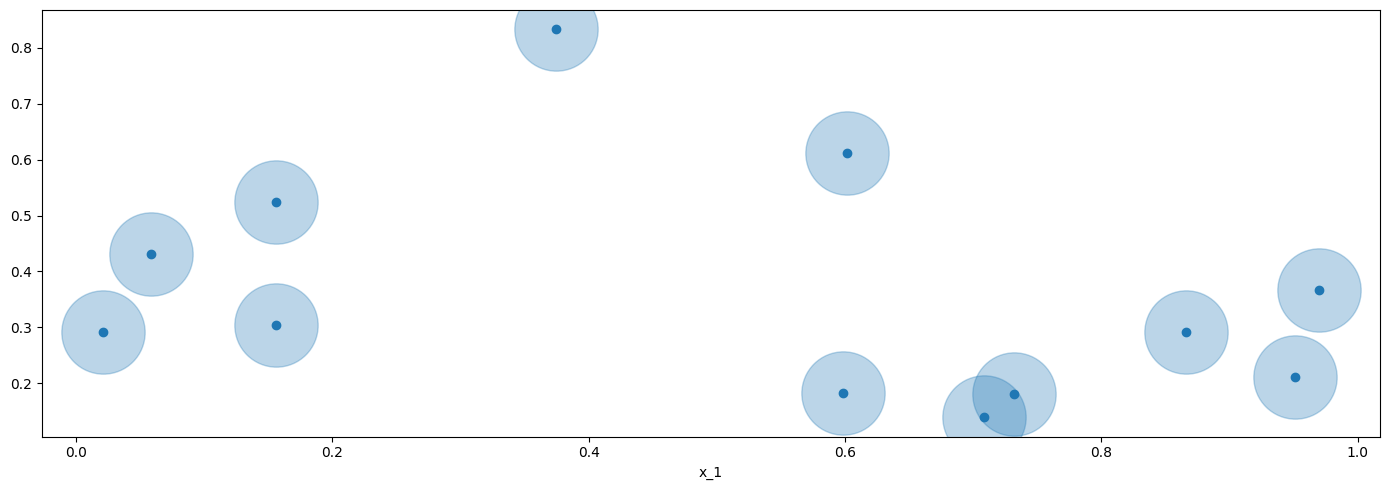

In [2]:
test_nsamples, test_ranges = 12, [(0., 1.), (0., 1.)]
X = util.sample_points(test_ranges, test_nsamples, mode='uniform', seed=42)
util.plot_2D_samplespace(X, figsize=figsize)

## Latin Hypercube Sampling

**Let's see a practical example**

...And here is the result of classical LHS:

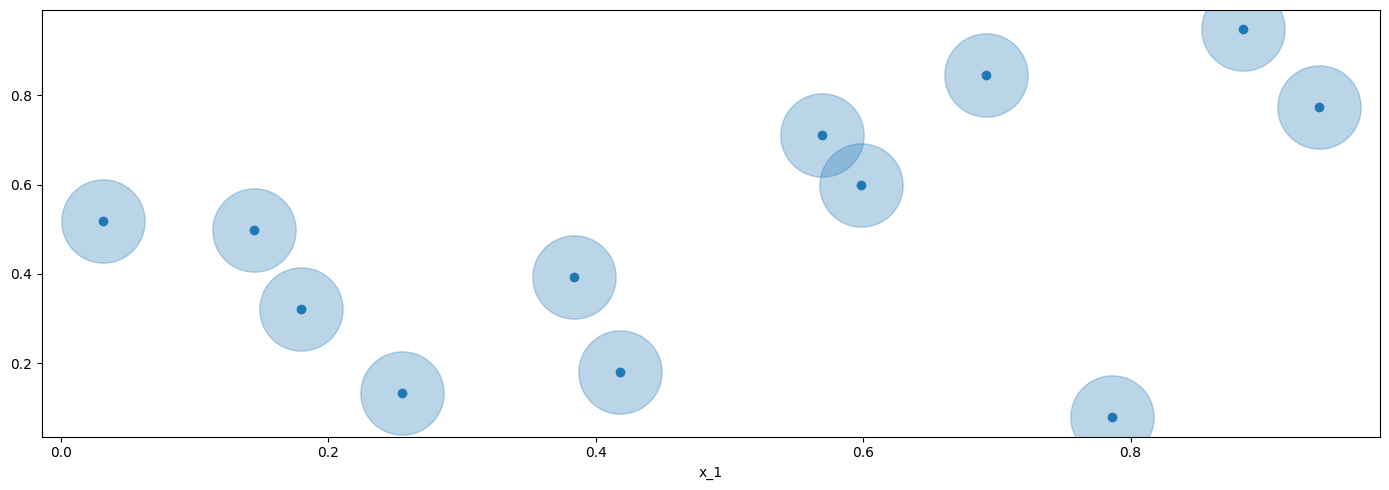

In [3]:
test_nsamples, test_ranges = 12, [(0., 1.), (0., 1.)]
X = util.sample_points(test_ranges, test_nsamples, mode='lhs', seed=42)
util.plot_2D_samplespace(X, figsize=figsize)

## Latin Hypercube Sampling

**The process can be further improved**

E.g. after sampling we can try to _maximize the minimum_ distance

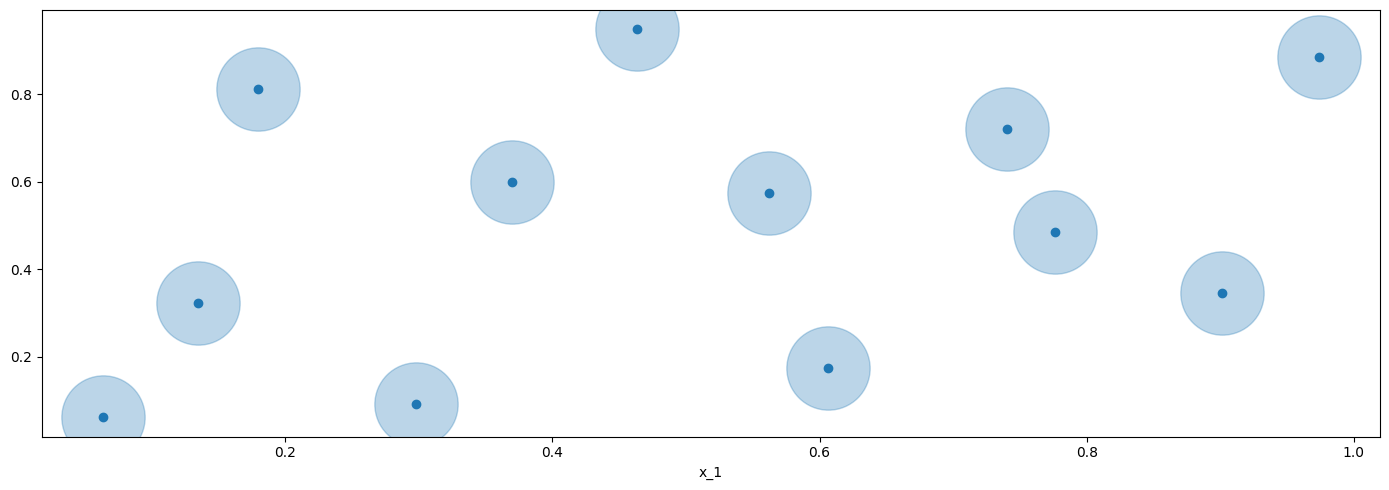

In [4]:
test_nsamples, test_ranges = 12, [(0., 1.), (0., 1.)]
X = util.sample_points(test_ranges, test_nsamples, mode='max_min', seed=42)
util.plot_2D_samplespace(X, figsize=figsize)

## Dataset Input

**We are now ready to generate our _dataset input_**

In [5]:
n_tr, n_ts = 10000, 2000
sir_tr_in = util.generate_SIR_input(max_samples=n_tr, mode='max_min', seed=42, normalize=True, max_beta=0.4)
sir_ts_in = util.generate_SIR_input(max_samples=n_ts, mode='max_min', seed=42, normalize=True, max_beta=0.4)
sir_tr_in.head()

,S,I,R,beta
0,0.352572,0.512310,0.135119,0.167925
1,0.175114,0.707867,0.117019,0.100628
2,0.024010,0.836985,0.139005,0.048884
3,0.139277,0.247573,0.613150,0.367367
4,0.491191,0.195846,0.312963,0.067067


* We sample $S, I, R, \beta$ from $[0, 1]^3 \times [0, .4]$
* ...Then $S, I, R$ are normalized so that their sum is 1

This will reduce in some redundancy in the dataset

## Dataset Output

**We obtain the corresponding output via simulation**

In [6]:
%%time
gamma = 1/14
sir_tr_out = util.generate_SIR_output(sir_tr_in, gamma, 7)
sir_ts_out = util.generate_SIR_output(sir_ts_in, gamma, 7)
sir_tr_out.head()

CPU times: user 1.2 s, sys: 53.3 ms, total: 1.25 s
Wall time: 1.2 s


,S,I,R
0,0.201814,0.425756,0.372430
1,0.115945,0.474359,0.409696
2,0.019150,0.511369,0.469481
3,0.078295,0.196566,0.725139
4,0.453265,0.148189,0.398546


* We picked $\gamma = 1/14$ (this will be fixed in our use case)
* We simulate one week

## Training a Model

**We try with Linear Regression**

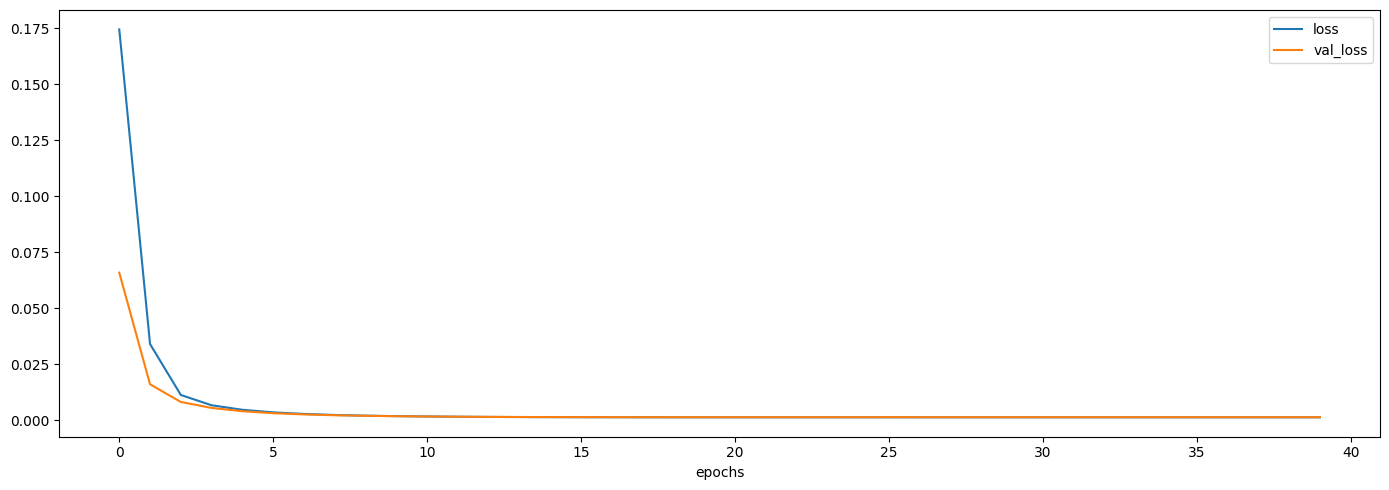

Model loss: 0.0012 (training) 0.0013 (validation)
R2: 0.95, MAE: 0.023, RMSE: 0.03 (training)
R2: 0.94, MAE: 0.023, RMSE: 0.04 (test)


In [7]:
nn0 = util.build_ml_model(input_size=4, output_size=3, hidden=[], name='LR')
history0 = util.train_ml_model(nn0, sir_tr_in, sir_tr_out, verbose=0, epochs=100)
util.plot_training_history(history0, figsize=figsize)
util.print_ml_metrics(nn0, sir_tr_in, sir_tr_out, 'training')
util.print_ml_metrics(nn0, sir_ts_in, sir_ts_out, 'test')

## Training a Model

**...And with a shallow Neural Network**

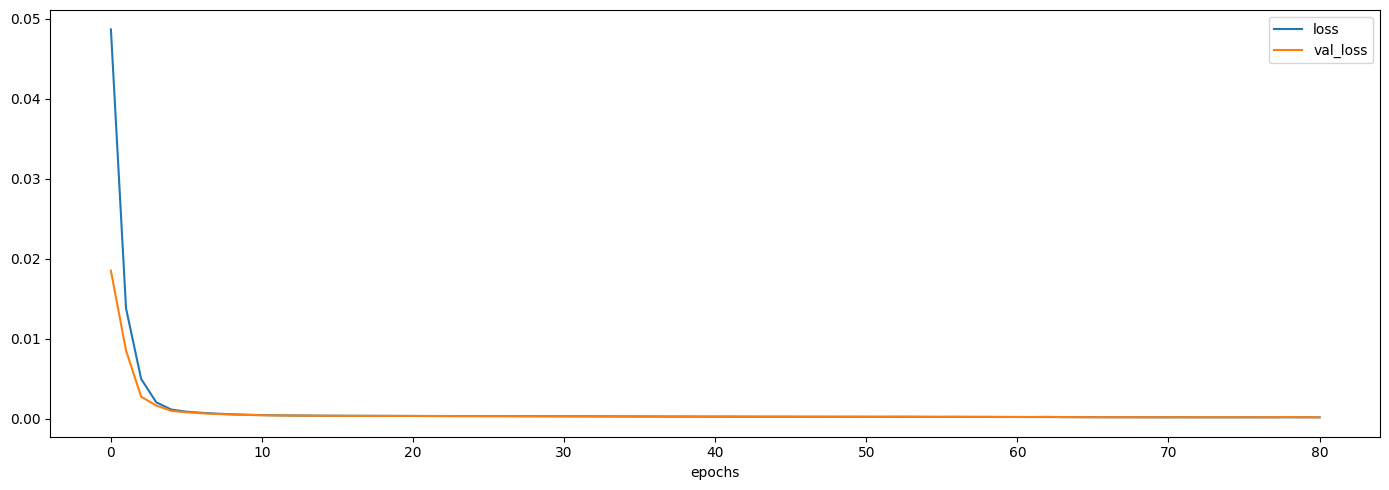

Model loss: 0.0002 (training) 0.0002 (validation)
R2: 0.99, MAE: 0.0081, RMSE: 0.01 (training)
R2: 0.99, MAE: 0.0083, RMSE: 0.01 (test)


In [8]:
nn1 = util.build_ml_model(input_size=4, output_size=3, hidden=[8], name='MLP')
history1 = util.train_ml_model(nn1, sir_tr_in, sir_tr_out, verbose=0, epochs=100)
util.plot_training_history(history1, figsize=figsize)
util.print_ml_metrics(nn1, sir_tr_in, sir_tr_out, 'training')
util.print_ml_metrics(nn1, sir_ts_in, sir_ts_out, 'test')

## Considerations and Next Steps

**We will save both models for later**

In [9]:
util.save_ml_model(nn0, 'nn0')
util.save_ml_model(nn1, 'nn1')

* The network is much better in terms of accuracy
* ...But the Linear Regressor is simpler!

Hence, the approaches provide different trade offs

**We are halfway there**

We now have our ML model(s)!

* We need to understand how they can be embedded in an optimization model
* ...And we need to define our optimization model itself